In [50]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

plt.rcParams.update({'font.size': 7})

In [51]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.state = env.reset()
        self.action = None
        self.done = False

    def step(self):
        self.state, reward, self.done, _ = self.env.step(self.action)
        return reward

    def act(self, action):
        self.action = action

    def reset(self):
        self.state = self.env.reset()
        self.action = None
        self.done = False

##### Deterministic Environment: $P(s',r|s,a)=\{0,1\}$
##### Stochastic Environment: $\sum_{s',r}P(s',r|s,a)=1$

In [52]:
class GridWorld(gym.Env):
    def __init__(self, verbose=False, env_type='Deterministic'):
        self.grid_size = 10
        self.start = (0, 0)
        self.goal_reward_pairs = [[(0, 2), 1.5], [(7, 8), -2], [(8, 7), -2], [(8, 3), 4], [(9, 9), 5], [(4, 7), -5]]
        self.ultimate_goal = self.goal_reward_pairs[-1][0]
        self.ultimate_reward = self.goal_reward_pairs[-1][1]
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(self.grid_size ** 2)
        self.verbose = verbose
        self.env_type = env_type
        self.timePenalty = 0
        self.reset()

    def reset(self):
        self.state = self.start
        self.timePenalty = 0
        return self.state

    def step(self, action):
        if self.env_type == 'Deterministic': # deterministic environment enabled
            x, y = self.state
            if action == 0:
                x = max(x - 1, 0) # move left
            elif action == 1:
                x = min(x + 1, self.grid_size - 1) # move right
            elif action == 2:
                y = max(y - 1, 0) # move down
            elif action == 3:
                y = min(y + 1, self.grid_size - 1) # move up
            self.state = (x, y)
        
        elif self.env_type == 'Stochastic': # stochastic environment enabled
            # at (9,8), give a 20% chance that the agent will be teleported to to (0,7)
            x, y = self.state
            teleported = False
            if x == 9 and y == 8 and np.random.random() <= 0.2:
                self.state = (0,7)
                if self.verbose:
                    print('TELEPORTED')
                teleported = True
            if not teleported:
                if action == 0:
                    x = max(x - 1, 0) # move left
                    if np.random.random() < 0.15:
                        y = max(y - 1, 0) # move left then down
                elif action == 1:
                    x = min(x + 1, self.grid_size - 1) # move right
                    if np.random.random() < 0.15:
                        y = max(y - 1, 0) # move right then down
                elif action == 2:
                    y = max(y - 1, 0) # move down
                    if np.random.random() < 0.15:
                        y = max(y - 1, 0) # move down then down
                elif action == 3:
                    y = min(y + 1, self.grid_size - 1) # move up 
                    if np.random.random() < 0.15:
                        y = max(y - 1, 0) # move up then down
                self.state = (x, y)

        reward = self.reward(self.state)
        done = self.state == self.ultimate_goal # done if we reach the +5 reward at (9, 9)

        if done:
            reward -= self.timePenalty # subtract the cumulative incurred time penalty for each run
            self.timePenalty = 0

        if self.verbose:
            print('action:', action, 'state:', self.state, 'reward:', reward, 'done:', done)
        return self.state, reward, done, {}
    
    def reward(self, state):
        self.timePenalty += 0.1 # incur a penalty of 0.1 for each time step
        for goal, reward in self.goal_reward_pairs:
            if state == goal:
                return reward
        return 0

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        for goal, reward in self.goal_reward_pairs:
            x, y = goal
            grid[y, x] = reward
            plt.text(goal[0], goal[1], 'R='+str(reward), ha='center', va='center')
        # teleporting square
        grid[9,8] = 10
        plt.text(8, 9, 'Teleporter', ha='center', va='center')

        x, y = self.state
        grid[y, x] = -1
        plt.text(self.state[0], self.state[1], 'Agent=('+str(self.state[0])+','+str(self.state[1])+')', ha='center', va='center')
        #plt.imshow(grid, cmap='viridis')
        # show x and y ticks between 0 and 9
        plt.xticks(np.arange(0, self.grid_size, 1))
        plt.yticks(np.arange(0, self.grid_size, 1))
        plt.imshow(grid, cmap='viridis',origin='lower')
        plt.show()

In [53]:
env = GridWorld(verbose=True, env_type='Deterministic')
env.reset()

agent = Agent(env)
agent.reset()

##### 10 Time Steps in Deterministic Environment

action: 2 state: (0, 0) reward: 0 done: False


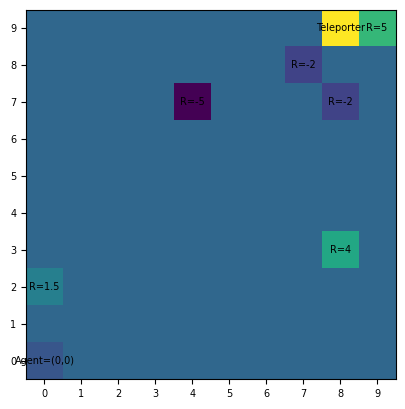

action: 1 state: (1, 0) reward: 0 done: False


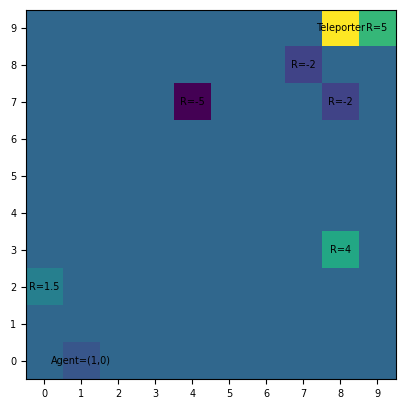

action: 1 state: (2, 0) reward: 0 done: False


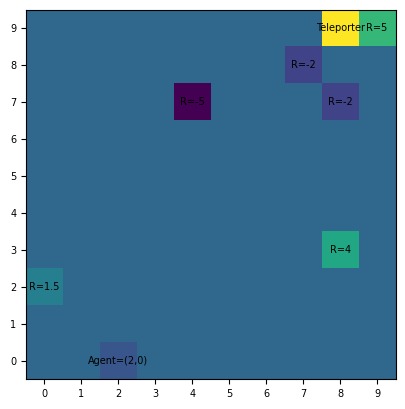

action: 0 state: (1, 0) reward: 0 done: False


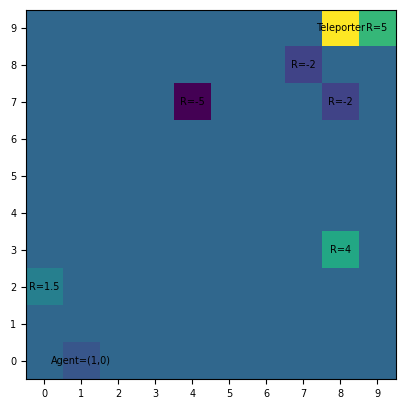

action: 1 state: (2, 0) reward: 0 done: False


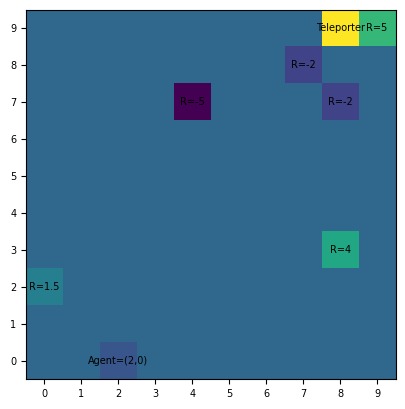

action: 3 state: (2, 1) reward: 0 done: False


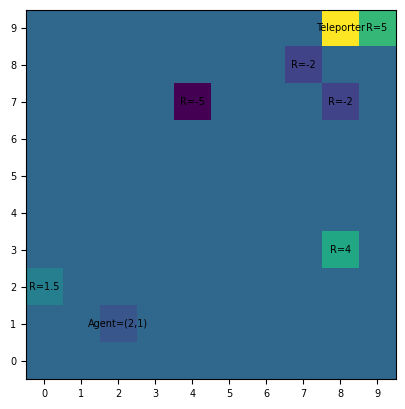

action: 3 state: (2, 2) reward: 0 done: False


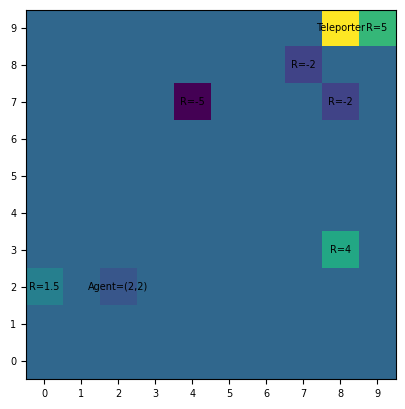

action: 2 state: (2, 1) reward: 0 done: False


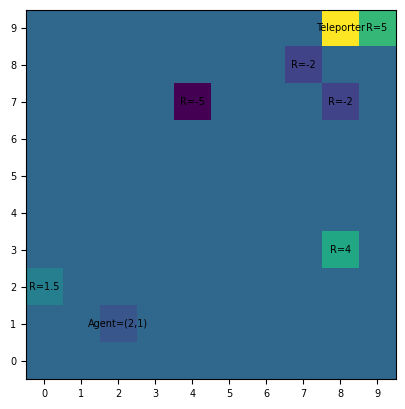

action: 0 state: (1, 1) reward: 0 done: False


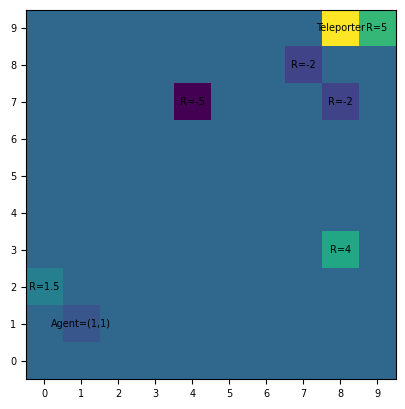

action: 3 state: (1, 2) reward: 0 done: False


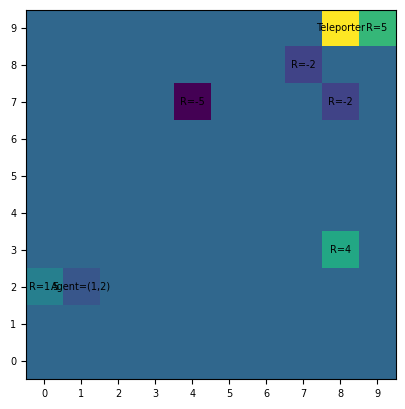

In [54]:
for _ in range(10):
    agent.act(env.action_space.sample())
    agent.step()
    env.render()

In [55]:
agent.reset()
env.reset()
env = GridWorld(verbose=True, env_type='Stochastic')
agent = Agent(env)

##### 10 Time Steps in Stochastic Environment

action: 3 state: (0, 1) reward: 0 done: False


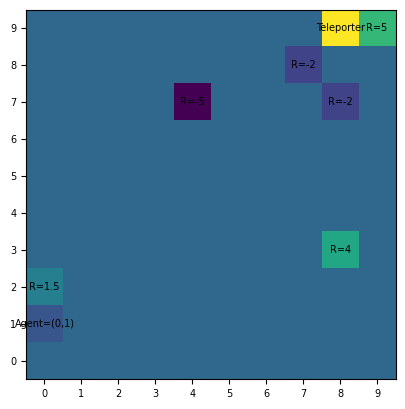

action: 1 state: (1, 1) reward: 0 done: False


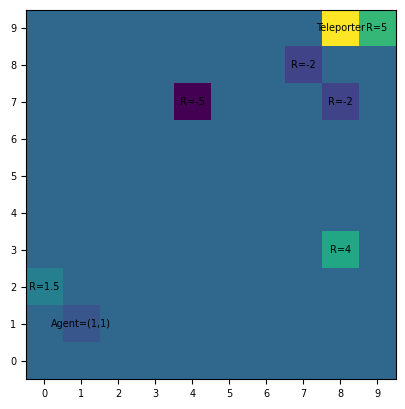

action: 0 state: (0, 1) reward: 0 done: False


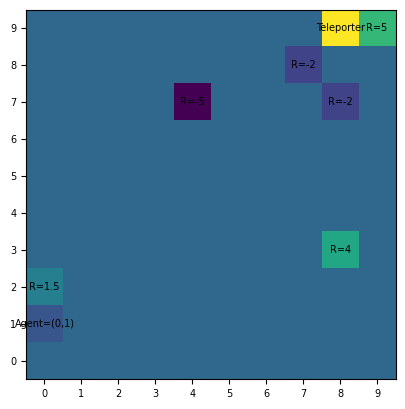

action: 3 state: (0, 1) reward: 0 done: False


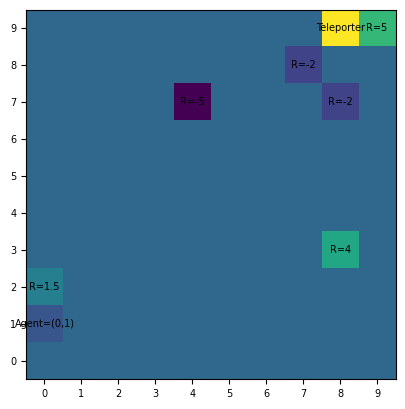

action: 3 state: (0, 2) reward: 1.5 done: False


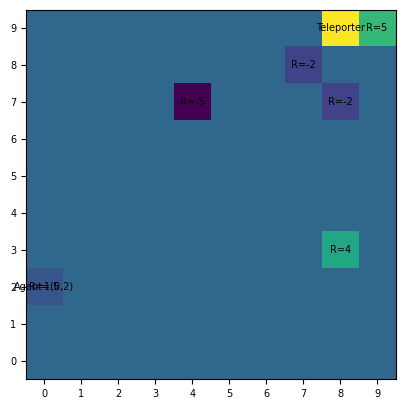

action: 0 state: (0, 2) reward: 1.5 done: False


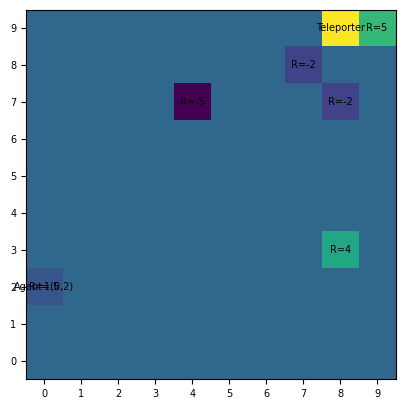

action: 0 state: (0, 2) reward: 1.5 done: False


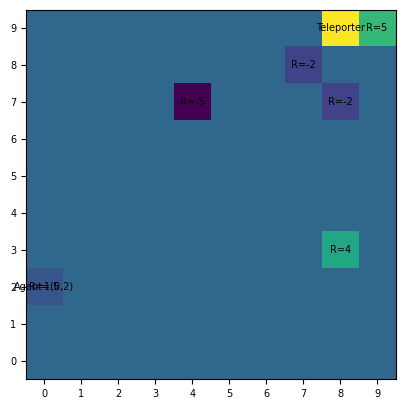

action: 0 state: (0, 2) reward: 1.5 done: False


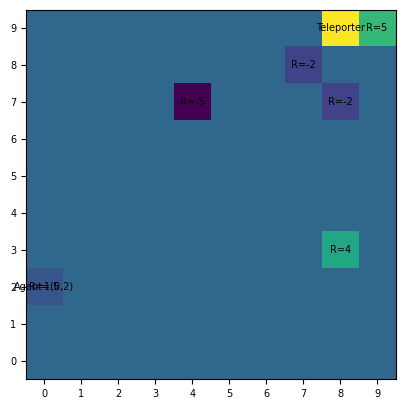

action: 2 state: (0, 1) reward: 0 done: False


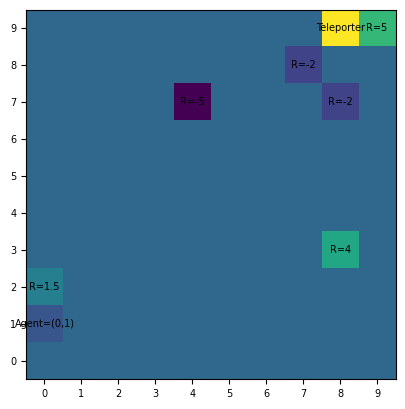

action: 3 state: (0, 2) reward: 1.5 done: False


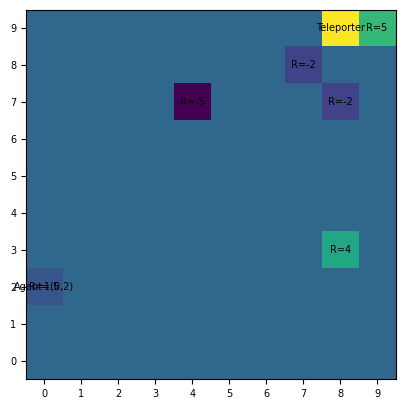

In [56]:
for _ in range(10):
    agent.act(env.action_space.sample())
    agent.step()
    env.render()

##### Distribution of number of timesteps in random walk in deterministic / stochastic environment

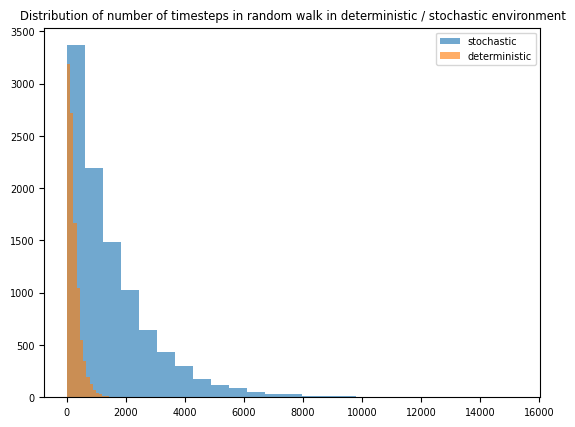

In [57]:
agent.reset()
env.reset()
env = GridWorld(verbose=False, env_type='Deterministic')
agent = Agent(env)

countListDeterministic = []
for i in range(10000):
    count = 0
    while not agent.done:
        agent.act(env.action_space.sample())
        agent.step()
        #env.render()
        count += 1
    env.reset()
    agent.reset()
    countListDeterministic.append(count)

agent.reset()
env.reset()
env = GridWorld(verbose=False, env_type='Stochastic')
agent = Agent(env)

countListStochastic = []
for i in range(10000):
    count = 0
    while not agent.done:
        agent.act(env.action_space.sample())
        agent.step()
        #env.render()
        count += 1
    env.reset()
    agent.reset()
    countListStochastic.append(count)

plt.title('Distribution of number of timesteps in random walk in deterministic / stochastic environment')
plt.hist(countListStochastic, bins=25, alpha=0.635, label='stochastic')
plt.hist(countListDeterministic, bins=25, alpha=0.635, label='deterministic')
plt.legend(loc='upper right')
plt.show()